# CIFAR-10 and CIFAR-100
## Part 1: Baseline experiments (coursework 3)
The main aim of the first part of the mini-project is to build baseline systems for the dataset you have chosen
to work on. In this part you should investigate feed-forward networks, keeping any investigations into more
complex architectures (e.g. convolutional networks and recurrent networks) until part 2. (For the Million Song
Dataset, this means that you should use the fixed-length variant of the data.) Things you could explore in
part 1 include different **activation functions, different hidden layer depths and widths, learning rate schedules,
normalisation, and regularisation**. You should design and carry out a number of experiments, making it clear in
your report what research questions are being investigated. You should present the results clearly and concisely
in your report, and provide a discussion of the results, with conclusions related to the initial research questions.

First fix all of the directory paths. This is something that should be at the top of any MLP project (since after setting up my MLP env I decided to move the mlpractical dir to Google Drive). All CIFAR files are in a local directory *not* within mlpractical.

In [1]:
import os

if 'fixed_dirs' not in locals():
    
    print 'fixing directories...'
    
    # Change working directory to mlpractical within Google Drive
    old_wd = os.getcwd()  # '/Users/sipola/Google Drive/mlpractical/notebooks'
    print 'old_wd: {}'.format(old_wd)
    new_wd = '/Users/sipola/Google Drive/mlpractical'
    print 'new_wd: {}'.format(new_wd)
    os.chdir(new_wd)
    
    # Fix data directory
    print 'old MLP_DATA_DIR: {}'.format(os.environ['MLP_DATA_DIR'])
    os.environ['MLP_DATA_DIR'] = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/mlp/data'
    print 'new MLP_DATA_DIR: {}'.format(os.environ['MLP_DATA_DIR'])
    
    # Confirm directories have been fixed
    fixed_dirs = True

fixing directories...
old_wd: /Users/sipola/Google Drive/mlpractical/notebooks
new_wd: /Users/sipola/Google Drive/mlpractical
old MLP_DATA_DIR: /Users/sipola/mlpractical/data
new MLP_DATA_DIR: /Users/sipola/Google Drive/education/coursework/graduate/edinburgh/mlp/data


Finish importing libraries.

In [2]:
import datetime
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
from collections import OrderedDict
import pickle
import time
%matplotlib inline

In [3]:
from IPython.display import display, HTML
import datetime

def show_graph(graph_def, frame_size=(900, 600)):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:{height}px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(height=frame_size[1], data=repr(str(graph_def)), id='graph'+timestamp)
    iframe = """
        <iframe seamless style="width:{width}px;height:{height}px;border:0" srcdoc="{src}"></iframe>
    """.format(width=frame_size[0], height=frame_size[1] + 20, src=code.replace('"', '&quot;'))
    display(HTML(iframe))

Define the save directory and functions for creating and deleting files within a directory.

In [4]:
save_path_main = 'run/coursework3/'

def create_and_return_path(folder_name,
                           save_path_main,
                           date_as_str = datetime.datetime.today().strftime('%Y-%m-%d')):
    save_path = os.path.join(save_path_main, folder_name, date_as_str)
    print 'path created: ' + save_path
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    return save_path

def clear_dir(folder):
    print 'deleting files in: ' + folder
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

Start project...

In [5]:
train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)

In [6]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

In [7]:
# inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
# targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
# num_hidden = 200

# with tf.name_scope('fc-layer-1'):
#     hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
# with tf.name_scope('output-layer'):
#     outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

# with tf.name_scope('error'):
#     error = tf.reduce_mean(
#         tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
# with tf.name_scope('accuracy'):
#     accuracy = tf.reduce_mean(tf.cast(
#             tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
#             tf.float32))

# with tf.name_scope('train'):
#     train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(error)
    
# init = tf.global_variables_initializer()

# Test number of hidden layers and number of hidden units

In [41]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'num_hidden_layers_and_units'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

# Initialize errors
stats = OrderedDict()

num_epoch = 20
stats_interval = 1

num_hlayers_list = [1, 2, 3, 4, 5]
num_hidden_list = [50, 100, 200, 300]
for num_hlayers in num_hlayers_list:
    for num_hidden in num_hidden_list:
        
        print '=========='
        print 'num_hlayers: {0}; num_hidden: {1}'.format(num_hlayers, num_hidden)
        stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
        
        if num_hlayers > 3 & num_hidden > 200:
            print 'skipping...'
            continue

        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        
        with tf.name_scope('fc-layer-1'):
            hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)

        if num_hlayers == 1:
            with tf.name_scope('output-layer'):
                outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

        if num_hlayers == 2:
            with tf.name_scope('fc-layer-2'):
                hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
            with tf.name_scope('output-layer'):
                outputs = fully_connected_layer(hidden_2, num_hidden, train_data.num_classes, tf.identity)

        if num_hlayers == 3:
            with tf.name_scope('fc-layer-2'):
                hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
            with tf.name_scope('fc-layer-3'):
                hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
            with tf.name_scope('output-layer'):
                outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

        if num_hlayers == 4:
            with tf.name_scope('fc-layer-2'):
                hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
            with tf.name_scope('fc-layer-3'):
                hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
            with tf.name_scope('fc-layer-4'):
                hidden_4 = fully_connected_layer(hidden_3, num_hidden, num_hidden)
            with tf.name_scope('output-layer'):
                outputs = fully_connected_layer(hidden_4, num_hidden, train_data.num_classes, tf.identity)
        
        if num_hlayers == 5:
            with tf.name_scope('fc-layer-2'):
                hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
            with tf.name_scope('fc-layer-3'):
                hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
            with tf.name_scope('fc-layer-4'):
                hidden_4 = fully_connected_layer(hidden_3, num_hidden, num_hidden)
            with tf.name_scope('fc-layer-5'):
                hidden_5 = fully_connected_layer(hidden_4, num_hidden, num_hidden)
            with tf.name_scope('output-layer'):
                outputs = fully_connected_layer(hidden_5, num_hidden, train_data.num_classes, tf.identity)

        with tf.name_scope('error'):
            error = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(
                    tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                    tf.float32))

        with tf.name_scope('train'):
            train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(error)

        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:

            sess.run(init)
            t0 = time.time()
            
            for e in range(num_epoch):

                # if (e + 1) % 5 != 0:
                #     _ = sess.run(train_step, feed_dict={inputs: input_batch, targets: target_batch})

                # else:
                
                t0_epoch = time.time()

                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch})
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                # print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                #       .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                # print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                #        .format(valid_error, valid_accuracy))
                print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} err(valid)={3:.2f} acc(valid)={4:.2f} time={5}'
                      .format(e + 1, running_error, running_accuracy, valid_error, valid_accuracy, time.time()-t0_epoch))

                # Store metrics
                stats_one['err(train)'].append(running_error)
                stats_one['acc(train)'].append(running_accuracy)
                stats_one['err(valid)'].append(valid_error)
                stats_one['acc(valid)'].append(valid_accuracy)
                
        stats_one['time'] = time.time() - t0
        stats[(num_hlayers, num_hidden)] = stats_one

# Pickle all important objects
pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

path created: run/coursework3-4/num_hidden_layers_and_units/2017-02-09
deleting files in: run/coursework3-4/num_hidden_layers_and_units/2017-02-09
num_hlayers: 1; num_hidden: 50
End of epoch 01: err(train)=2.06 acc(train)=0.24 err(valid)=0.83 acc(valid)=0.12 time=4.80923509598
End of epoch 02: err(train)=1.93 acc(train)=0.29 err(valid)=1.94 acc(valid)=0.29 time=4.80664205551
End of epoch 03: err(train)=1.90 acc(train)=0.30 err(valid)=1.90 acc(valid)=0.30 time=4.76423716545
End of epoch 04: err(train)=1.87 acc(train)=0.32 err(valid)=1.87 acc(valid)=0.33 time=3.9832611084
End of epoch 05: err(train)=1.86 acc(train)=0.32 err(valid)=1.85 acc(valid)=0.33 time=3.93755984306
End of epoch 06: err(train)=1.84 acc(train)=0.33 err(valid)=1.86 acc(valid)=0.33 time=3.93057918549
End of epoch 07: err(train)=1.83 acc(train)=0.33 err(valid)=1.84 acc(valid)=0.34 time=3.93125987053
End of epoch 08: err(train)=1.83 acc(train)=0.34 err(valid)=1.85 acc(valid)=0.33 time=3.91968393326
End of epoch 09: err(tr

ValueError: x and y must have same first dimension

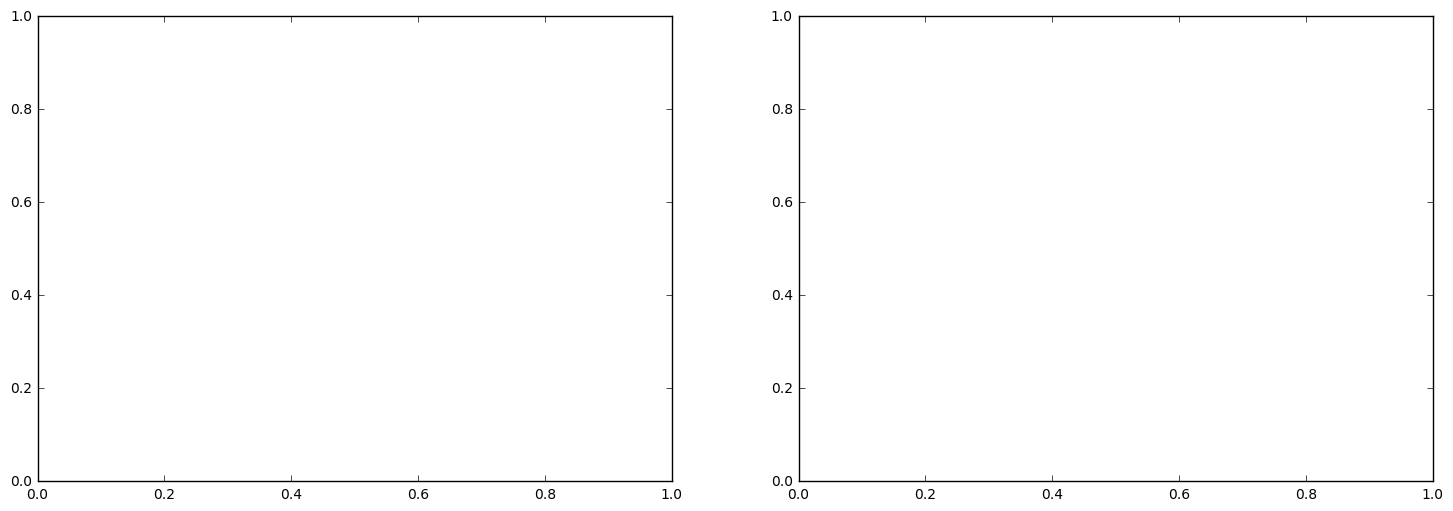

In [152]:
subdir = 'num_hidden_layers_and_units'

# Unpickle all important objects
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))

# Plot stuff
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for (num_hlayers, num_hidden), stats_sub in stats.iteritems():
    ax1.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(train)'], '0.1', label='{0} hidden layers w/ {1} units'.format(num_hlayers, num_hidden), alpha = 0.2)
    ax2.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(valid)'], '0.1', label='{0} hidden layers w/ {1} units'.format(num_hlayers, num_hidden), alpha = 0.2)
# ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
# ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

plt.savefig(os.path.join(save_path, 'layers.pdf'))

In [154]:
for (num_hlayers, num_hidden), values in stats.iteritems():
    print num_hlayers, num_hidden, values['err(valid)'][-1], values['acc(valid)'][-1], values['time']

1 50 1.81525135338 0.348700000122 81.61364007
1 100 1.68662969053 0.410699999556 112.154309034
1 200 1.5793725282 0.438299998939 164.53019309
1 300 1.53505078256 0.458599998057 270.340946913
2 50 1.58940701842 0.438999999166 84.4808928967
2 100 1.55628594875 0.452599999756 130.032054901
2 200 1.51398308933 0.474899999052 228.51592207
2 300 1.49619887531 0.490799999088 334.693989992
3 50 1.51148594439 0.467199998945 95.7745449543
3 100 1.51373376727 0.473100000471 145.794965029
3 200 1.51180914313 0.489999999255 233.387941122
3 300 1.56336349517 0.486299999505 408.427433014
4 50 1.57463835478 0.447499998808 93.9176208973
4 100 1.50119962752 0.476799999326 143.72232008
4 200 1.59730272233 0.45729999885 234.259918928
4 300 1.62354115427 0.479899998903 1526.71201801
5 50 1.50836818874 0.468399999589 91.3246707916
5 100 1.56387725115 0.453799998462 124.122315884
5 200 1.56842294812 0.479499998689 209.09931016
5 300 1.61440288484 0.482999998778 319.120898962


Figure out how to better iterate over layers. Can also use this to visualize architectures.

In [145]:
num_hlayers = 1  # must be > 0
num_hidden = 200

graph = tf.Graph()

with graph.as_default():
    
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    # Initialize hidden layers
    hlayers = []
    
    # Create first hidden layer
    with tf.name_scope('fc-layer-1'):
        hlayers.append(fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden))
    
    # Create second, third, etc. hidden layers
    for hl in range(num_hlayers - 1):
        fc_layer_num = hl + 2
        with tf.name_scope('fc-layer-{}'.format(fc_layer_num)):
            hlayers.append(fully_connected_layer(hlayers[-1], num_hidden, num_hidden))
    
    # Create output layer
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hlayers[-1], num_hidden, train_data.num_classes, tf.identity)
        
    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(error)
        
show_graph(graph)

# Testing activation functions

path created: run/coursework3-4/activation_functions/2017-02-15
deleting files in: run/coursework3-4/activation_functions/2017-02-15
fun: relu
End of epoch 01: err(train)=1.92 acc(train)=0.30 err(valid)=1.80 acc(valid)=0.35 time=6.79470205307
End of epoch 02: err(train)=1.73 acc(train)=0.38 err(valid)=1.71 acc(valid)=0.39 time=5.97505307198
End of epoch 03: err(train)=1.67 acc(train)=0.40 err(valid)=1.69 acc(valid)=0.39 time=6.01781892776
End of epoch 04: err(train)=1.62 acc(train)=0.42 err(valid)=1.63 acc(valid)=0.41 time=6.06390190125
End of epoch 05: err(train)=1.57 acc(train)=0.44 err(valid)=1.56 acc(valid)=0.44 time=6.02812004089
End of epoch 06: err(train)=1.55 acc(train)=0.45 err(valid)=1.56 acc(valid)=0.45 time=6.08274006844
End of epoch 07: err(train)=1.52 acc(train)=0.45 err(valid)=1.58 acc(valid)=0.43 time=5.98927807808
End of epoch 08: err(train)=1.49 acc(train)=0.46 err(valid)=1.54 acc(valid)=0.46 time=6.02122211456
End of epoch 09: err(train)=1.47 acc(train)=0.47 err(vali

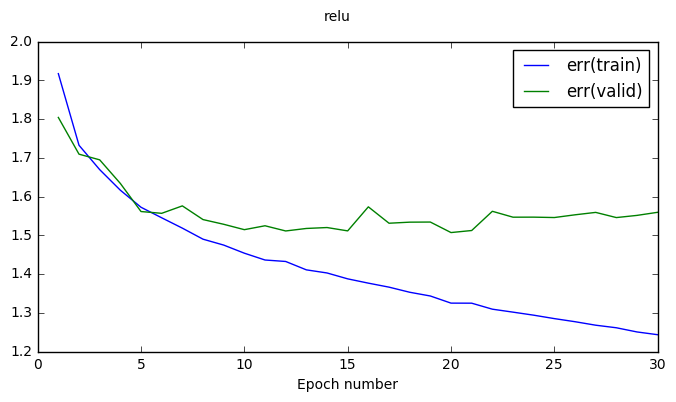

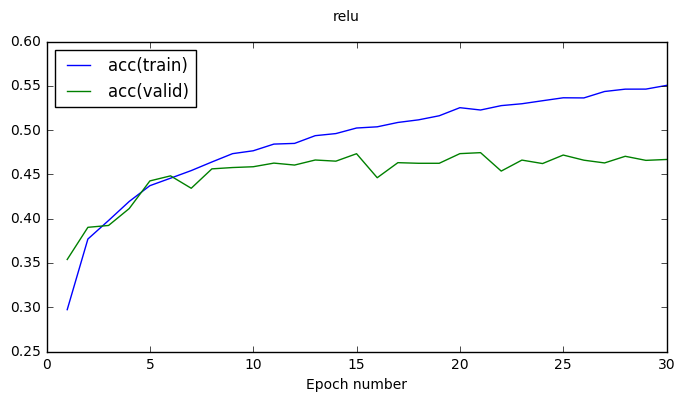

fun: dropout
End of epoch 01: err(train)=5.59 acc(train)=0.13 err(valid)=2.62 acc(valid)=0.14 time=6.93309283257
End of epoch 02: err(train)=2.36 acc(train)=0.17 err(valid)=2.20 acc(valid)=0.20 time=6.81154704094
End of epoch 03: err(train)=2.09 acc(train)=0.23 err(valid)=2.04 acc(valid)=0.24 time=6.68519806862
End of epoch 04: err(train)=2.03 acc(train)=0.24 err(valid)=2.02 acc(valid)=0.25 time=6.71114492416
End of epoch 05: err(train)=2.02 acc(train)=0.25 err(valid)=2.02 acc(valid)=0.24 time=6.83273911476
End of epoch 06: err(train)=2.01 acc(train)=0.25 err(valid)=2.03 acc(valid)=0.26 time=6.71411204338
End of epoch 07: err(train)=2.01 acc(train)=0.26 err(valid)=2.01 acc(valid)=0.26 time=6.7688639164
End of epoch 08: err(train)=2.00 acc(train)=0.27 err(valid)=2.04 acc(valid)=0.26 time=7.01493310928
End of epoch 09: err(train)=1.99 acc(train)=0.27 err(valid)=1.99 acc(valid)=0.26 time=7.57629704475
End of epoch 10: err(train)=1.98 acc(train)=0.27 err(valid)=2.00 acc(valid)=0.27 time=7.

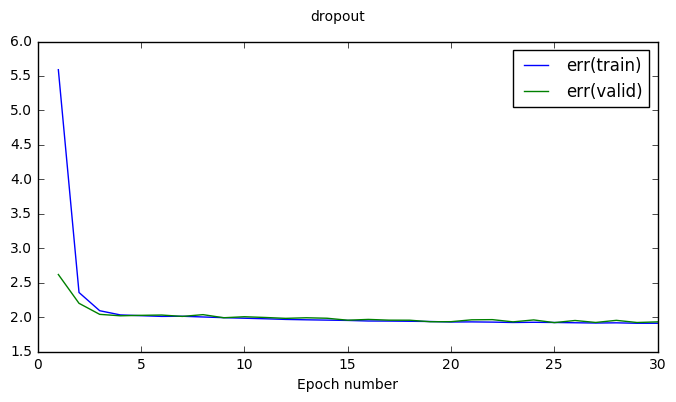

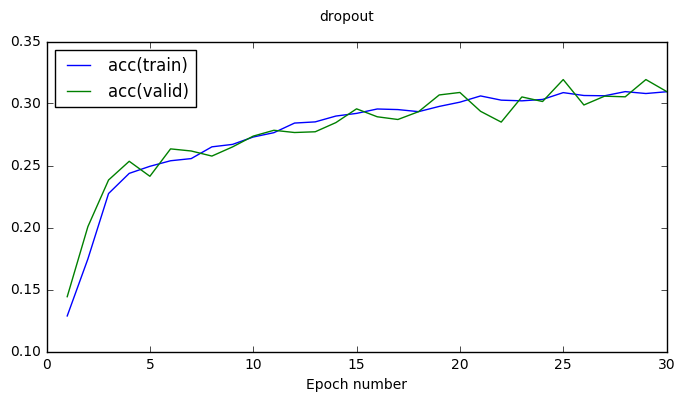

fun: sigmoid
End of epoch 01: err(train)=2.12 acc(train)=0.18 err(valid)=2.06 acc(valid)=0.19 time=6.37143015862
End of epoch 02: err(train)=2.00 acc(train)=0.24 err(valid)=1.92 acc(valid)=0.28 time=8.09993195534
End of epoch 03: err(train)=1.90 acc(train)=0.30 err(valid)=1.86 acc(valid)=0.31 time=5.94128704071
End of epoch 04: err(train)=1.86 acc(train)=0.31 err(valid)=1.85 acc(valid)=0.32 time=6.10268378258
End of epoch 05: err(train)=1.83 acc(train)=0.33 err(valid)=1.82 acc(valid)=0.33 time=5.86423897743
End of epoch 06: err(train)=1.81 acc(train)=0.34 err(valid)=1.82 acc(valid)=0.34 time=5.82587003708
End of epoch 07: err(train)=1.79 acc(train)=0.34 err(valid)=1.79 acc(valid)=0.35 time=5.85020899773
End of epoch 08: err(train)=1.77 acc(train)=0.35 err(valid)=1.78 acc(valid)=0.34 time=5.84161305428
End of epoch 09: err(train)=1.75 acc(train)=0.36 err(valid)=1.76 acc(valid)=0.36 time=5.86975598335
End of epoch 10: err(train)=1.74 acc(train)=0.37 err(valid)=1.78 acc(valid)=0.36 time=6

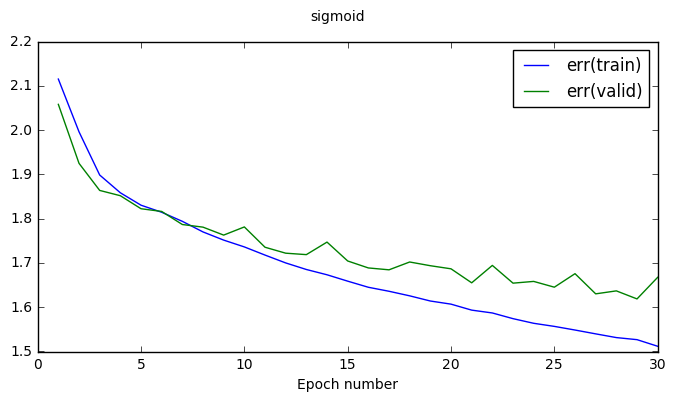

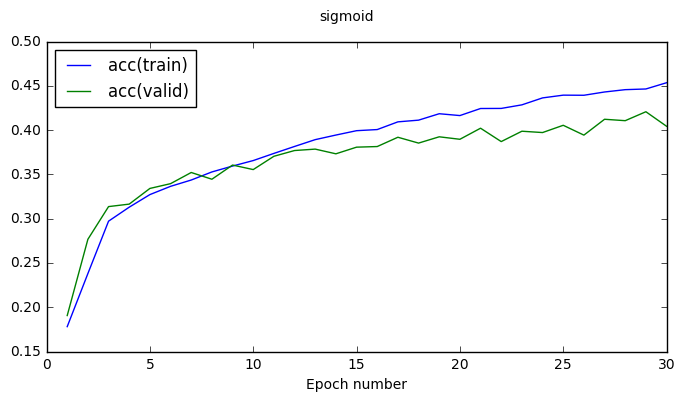

fun: tanh
End of epoch 01: err(train)=1.98 acc(train)=0.27 err(valid)=1.91 acc(valid)=0.30 time=6.08164191246
End of epoch 02: err(train)=1.87 acc(train)=0.32 err(valid)=1.84 acc(valid)=0.34 time=5.79487800598
End of epoch 03: err(train)=1.82 acc(train)=0.34 err(valid)=1.81 acc(valid)=0.35 time=5.82797217369
End of epoch 04: err(train)=1.80 acc(train)=0.35 err(valid)=1.86 acc(valid)=0.33 time=5.81008815765
End of epoch 05: err(train)=1.77 acc(train)=0.36 err(valid)=1.77 acc(valid)=0.36 time=5.76442503929
End of epoch 06: err(train)=1.77 acc(train)=0.36 err(valid)=1.78 acc(valid)=0.37 time=5.85680580139
End of epoch 07: err(train)=1.75 acc(train)=0.37 err(valid)=1.78 acc(valid)=0.36 time=5.75202202797
End of epoch 08: err(train)=1.73 acc(train)=0.38 err(valid)=1.77 acc(valid)=0.36 time=5.8792219162
End of epoch 09: err(train)=1.73 acc(train)=0.38 err(valid)=1.77 acc(valid)=0.37 time=5.84357595444
End of epoch 10: err(train)=1.72 acc(train)=0.38 err(valid)=1.74 acc(valid)=0.37 time=5.852

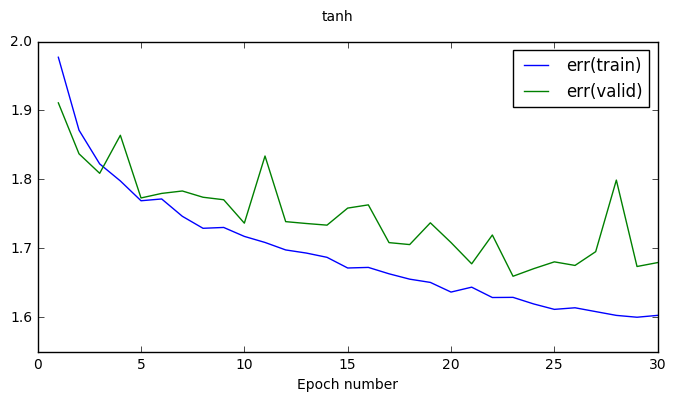

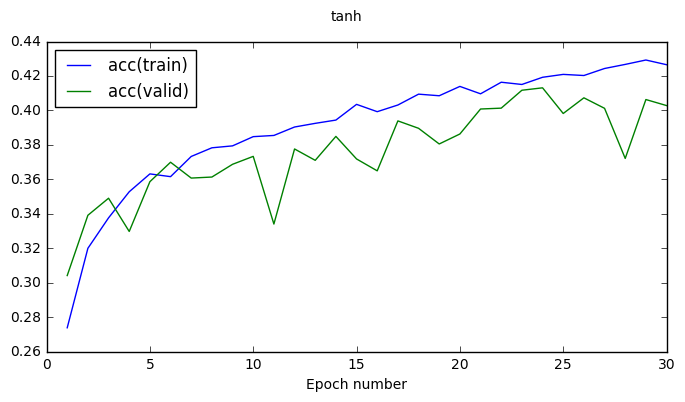

In [11]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'activation_functions'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

num_hlayers = 4
num_hidden = 100

stats = OrderedDict()

num_epoch = 30
stats_interval = 1

def dropout2(x):
    return tf.nn.dropout(x, 0.5, noise_shape=None, seed=None, name=None)

iter_strs = ['relu', 'dropout', 'sigmoid', 'tanh']
funs = [tf.nn.relu, dropout2, tf.sigmoid, tf.tanh]
if len(iter_strs) != len(funs):
    print 'lengths of funs and iter_strs DO NOT match. Bad!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
        
for fun, iter_str in zip(funs, iter_strs):
    
    print '=========='
    print 'fun: {}'.format(iter_str)
    stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
    
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    hlayers = []
    
    # Create first hidden layer. There must be at least one.
    with tf.name_scope('fc-layer-1'):
        hlayers.append(fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden, fun))
    
    # Create second, third, etc. hidden layers (if they exist)
    for hl in range(num_hlayers - 1):
        fc_layer_num = hl + 2
        with tf.name_scope('fc-layer-{}'.format(fc_layer_num)):
            hlayers.append(fully_connected_layer(hlayers[-1], num_hidden, num_hidden, fun))

    # Create output layer
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hlayers[-1], num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))
        
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(error)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:

        sess.run(init)
        t0 = time.time()

        for e in range(num_epoch):

            t0_epoch = time.time()
            
            # Training
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            
            # Validation
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} err(valid)={3:.2f} acc(valid)={4:.2f} time={5}'
                  .format(e + 1, running_error, running_accuracy, valid_error, valid_accuracy, time.time()-t0_epoch))

            # Store metrics
            stats_one['err(train)'].append(running_error)
            stats_one['acc(train)'].append(running_accuracy)
            stats_one['err(valid)'].append(valid_error)
            stats_one['acc(valid)'].append(valid_accuracy)
            
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['err(train)', 'err(valid)']:
        ax_1.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    fig_1.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'error_' + iter_str + '.pdf'))

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    fig_2.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'acc_' + iter_str + '.pdf'))
                  
    plt.show()

    stats_one['time'] = time.time() - t0
    stats[iter_str] = stats_one

# Pickle all important objects
pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

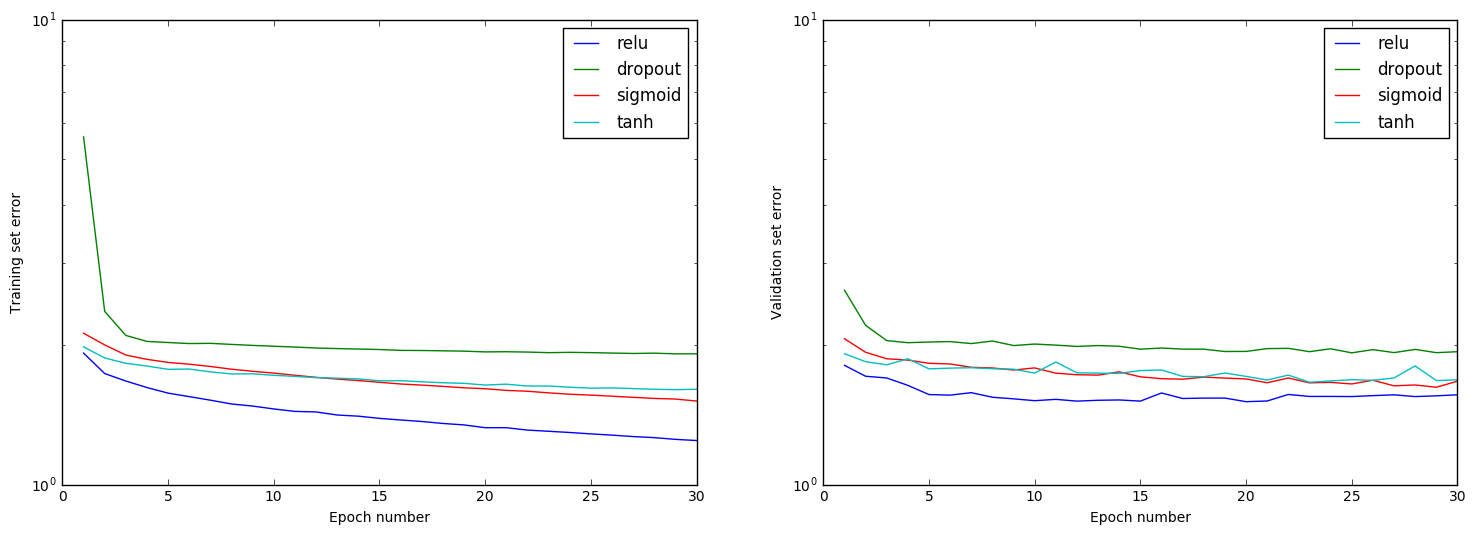

In [12]:
# Unpickle all important objects
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))

# Plot stuff
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for iter_str, stats_sub in stats.iteritems():
    ax1.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(train)'], label='{}'.format(iter_str))
    ax2.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(valid)'], label='{}'.format(iter_str))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

plt.savefig(os.path.join(save_path, 'activation_funs.pdf'))

# Testing learning rate schedules

In [179]:
def gradientdescent():
    return tf.train.GradientDescentOptimizer(0.01)

def adagrad():
    return tf.train.AdagradOptimizer(0.01)

def momentum():
    return tf.train.MomentumOptimizer(0.001, 0.9)

def adam():
    return tf.train.AdamOptimizer()

def rmsprop():
    return tf.train.RMSPropOptimizer(0.001)

path created: run/coursework3-4/optimizers/2017-02-09
deleting files in: run/coursework3-4/optimizers/2017-02-09
gradientdescent
End of epoch 01: err(train)=1.97 acc(train)=0.28 err(valid)=2.06 acc(valid)=0.28 time=9.50696587563
End of epoch 02: err(train)=1.78 acc(train)=0.37 err(valid)=1.75 acc(valid)=0.37 time=9.10935497284
End of epoch 03: err(train)=1.70 acc(train)=0.39 err(valid)=1.72 acc(valid)=0.39 time=5.95818996429
End of epoch 04: err(train)=1.65 acc(train)=0.41 err(valid)=1.62 acc(valid)=0.43 time=7.14745402336
End of epoch 05: err(train)=1.61 acc(train)=0.43 err(valid)=1.61 acc(valid)=0.43 time=6.52562379837
End of epoch 06: err(train)=1.57 acc(train)=0.44 err(valid)=1.67 acc(valid)=0.41 time=6.17349600792
End of epoch 07: err(train)=1.54 acc(train)=0.45 err(valid)=1.58 acc(valid)=0.44 time=6.92838096619
End of epoch 08: err(train)=1.52 acc(train)=0.46 err(valid)=1.57 acc(valid)=0.44 time=6.11551189423
End of epoch 09: err(train)=1.49 acc(train)=0.47 err(valid)=1.59 acc(va

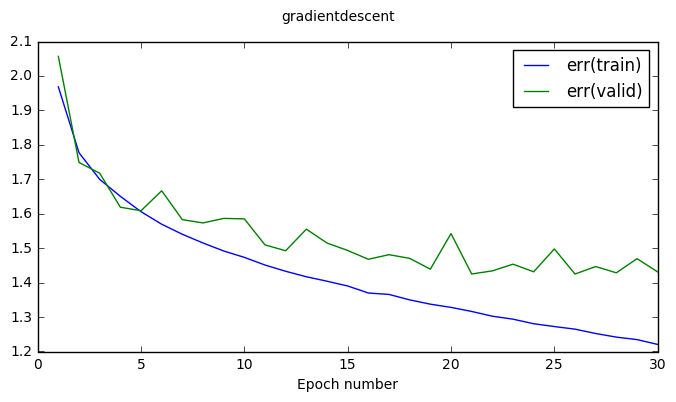

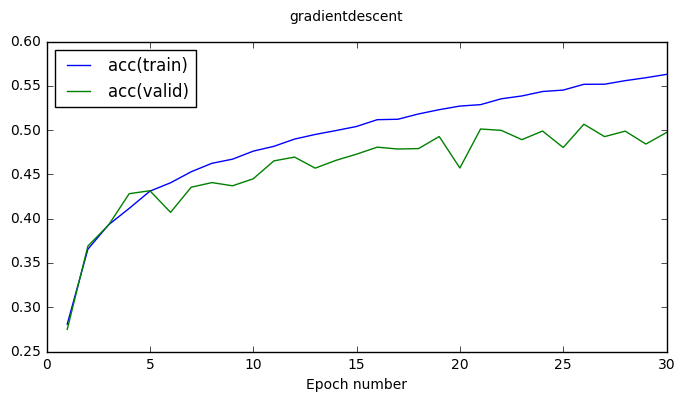

adagrad
End of epoch 01: err(train)=1.95 acc(train)=0.29 err(valid)=1.83 acc(valid)=0.34 time=9.44236207008
End of epoch 02: err(train)=1.75 acc(train)=0.37 err(valid)=1.70 acc(valid)=0.39 time=6.00225305557
End of epoch 03: err(train)=1.66 acc(train)=0.41 err(valid)=1.66 acc(valid)=0.41 time=5.82679891586
End of epoch 04: err(train)=1.60 acc(train)=0.43 err(valid)=1.61 acc(valid)=0.43 time=5.98020911217
End of epoch 05: err(train)=1.56 acc(train)=0.44 err(valid)=1.63 acc(valid)=0.43 time=6.82609796524
End of epoch 06: err(train)=1.52 acc(train)=0.46 err(valid)=1.58 acc(valid)=0.44 time=5.80355906487
End of epoch 07: err(train)=1.49 acc(train)=0.47 err(valid)=1.56 acc(valid)=0.45 time=6.31887984276
End of epoch 08: err(train)=1.47 acc(train)=0.48 err(valid)=1.52 acc(valid)=0.46 time=6.47861409187
End of epoch 09: err(train)=1.45 acc(train)=0.49 err(valid)=1.50 acc(valid)=0.47 time=6.60250878334
End of epoch 10: err(train)=1.42 acc(train)=0.49 err(valid)=1.49 acc(valid)=0.48 time=6.0859

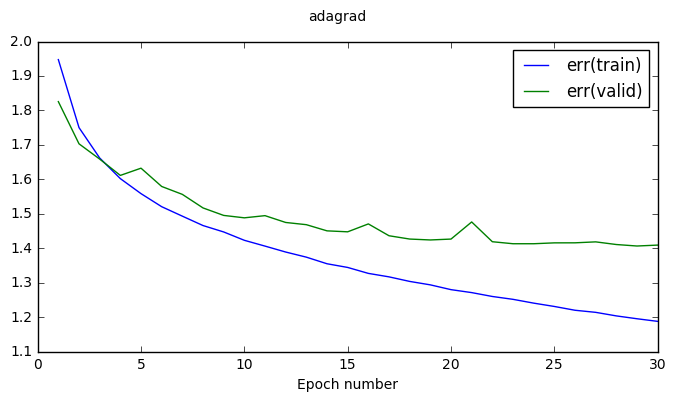

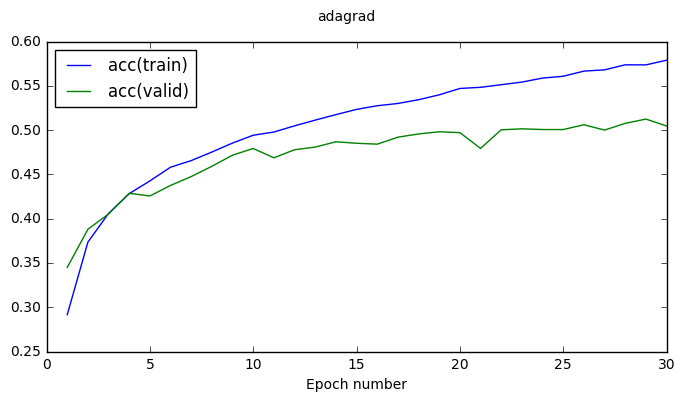

momentum
End of epoch 01: err(train)=1.96 acc(train)=0.29 err(valid)=1.81 acc(valid)=0.35 time=7.13493204117
End of epoch 02: err(train)=1.75 acc(train)=0.37 err(valid)=1.71 acc(valid)=0.39 time=5.55811500549
End of epoch 03: err(train)=1.67 acc(train)=0.40 err(valid)=1.69 acc(valid)=0.39 time=5.79255485535
End of epoch 04: err(train)=1.62 acc(train)=0.42 err(valid)=1.62 acc(valid)=0.42 time=5.61364197731
End of epoch 05: err(train)=1.57 acc(train)=0.44 err(valid)=1.59 acc(valid)=0.44 time=5.68442201614
End of epoch 06: err(train)=1.54 acc(train)=0.45 err(valid)=1.54 acc(valid)=0.45 time=5.71087384224
End of epoch 07: err(train)=1.51 acc(train)=0.46 err(valid)=1.57 acc(valid)=0.44 time=5.75252699852
End of epoch 08: err(train)=1.49 acc(train)=0.47 err(valid)=1.54 acc(valid)=0.46 time=5.8202419281
End of epoch 09: err(train)=1.47 acc(train)=0.47 err(valid)=1.52 acc(valid)=0.46 time=5.71073794365
End of epoch 10: err(train)=1.44 acc(train)=0.48 err(valid)=1.53 acc(valid)=0.46 time=5.7411

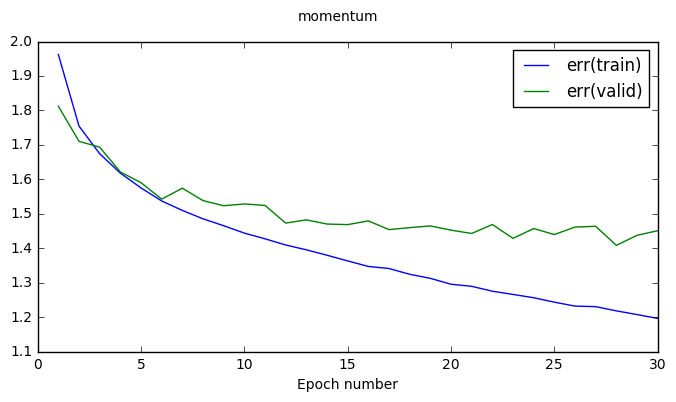

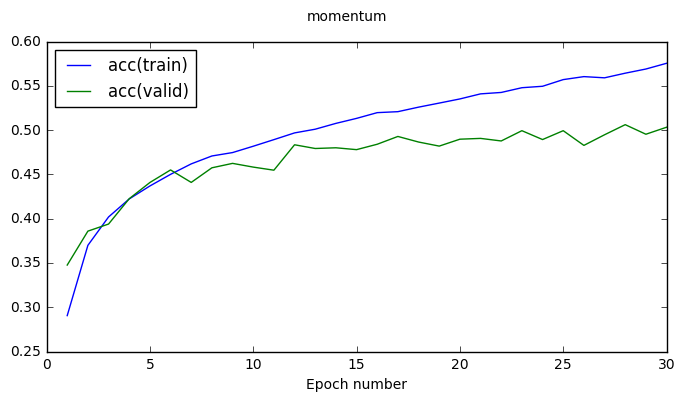

adam
End of epoch 01: err(train)=1.90 acc(train)=0.31 err(valid)=1.75 acc(valid)=0.37 time=13.0020830631
End of epoch 02: err(train)=1.71 acc(train)=0.38 err(valid)=1.69 acc(valid)=0.39 time=12.1356749535
End of epoch 03: err(train)=1.64 acc(train)=0.41 err(valid)=1.68 acc(valid)=0.39 time=10.4370341301
End of epoch 04: err(train)=1.60 acc(train)=0.42 err(valid)=1.64 acc(valid)=0.41 time=7.12465405464
End of epoch 05: err(train)=1.56 acc(train)=0.44 err(valid)=1.54 acc(valid)=0.45 time=6.9804391861
End of epoch 06: err(train)=1.53 acc(train)=0.45 err(valid)=1.54 acc(valid)=0.45 time=6.48813605309
End of epoch 07: err(train)=1.50 acc(train)=0.46 err(valid)=1.55 acc(valid)=0.45 time=6.36995816231
End of epoch 08: err(train)=1.47 acc(train)=0.47 err(valid)=1.54 acc(valid)=0.45 time=8.01997303963
End of epoch 09: err(train)=1.45 acc(train)=0.48 err(valid)=1.52 acc(valid)=0.46 time=7.89461612701
End of epoch 10: err(train)=1.43 acc(train)=0.49 err(valid)=1.51 acc(valid)=0.47 time=7.62555694

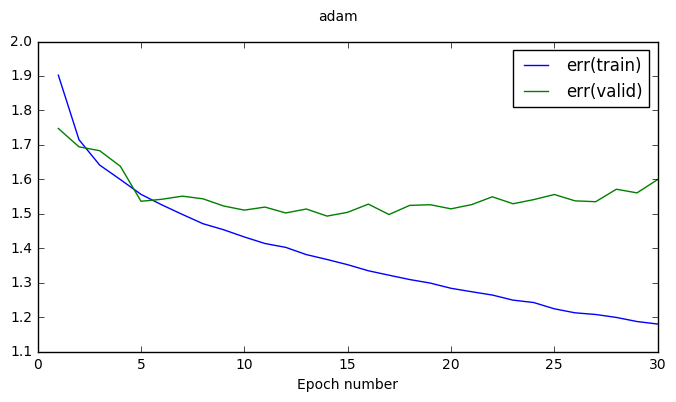

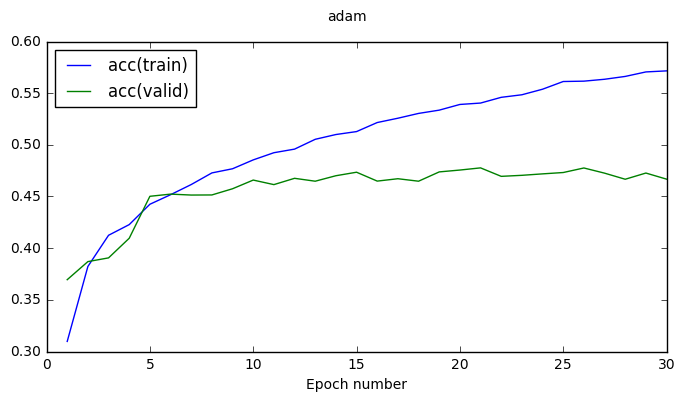

rmsprop
End of epoch 01: err(train)=2.03 acc(train)=0.25 err(valid)=1.81 acc(valid)=0.34 time=8.23206710815
End of epoch 02: err(train)=1.81 acc(train)=0.35 err(valid)=1.76 acc(valid)=0.37 time=7.11713910103
End of epoch 03: err(train)=1.73 acc(train)=0.38 err(valid)=1.67 acc(valid)=0.40 time=8.49105811119
End of epoch 04: err(train)=1.67 acc(train)=0.40 err(valid)=1.66 acc(valid)=0.40 time=7.22921586037
End of epoch 05: err(train)=1.63 acc(train)=0.41 err(valid)=1.70 acc(valid)=0.40 time=7.29784107208
End of epoch 06: err(train)=1.60 acc(train)=0.42 err(valid)=1.65 acc(valid)=0.43 time=6.54598784447
End of epoch 07: err(train)=1.58 acc(train)=0.43 err(valid)=1.60 acc(valid)=0.43 time=6.70602798462
End of epoch 08: err(train)=1.56 acc(train)=0.44 err(valid)=1.58 acc(valid)=0.44 time=6.78150200844
End of epoch 09: err(train)=1.55 acc(train)=0.45 err(valid)=1.62 acc(valid)=0.43 time=7.33125209808
End of epoch 10: err(train)=1.53 acc(train)=0.45 err(valid)=1.61 acc(valid)=0.44 time=6.4038

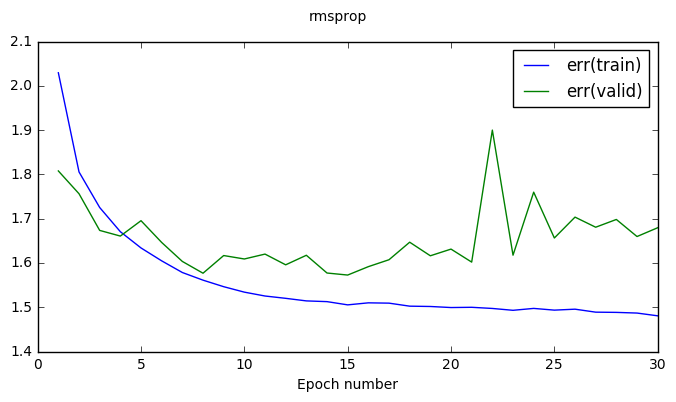

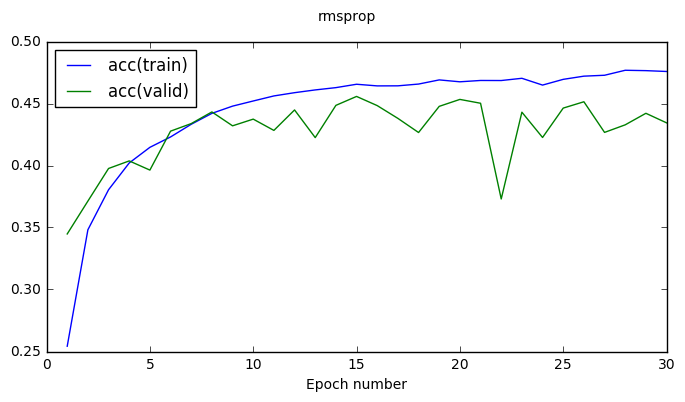

In [180]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'optimizers'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

num_hlayers = 4
num_hidden = 100

stats = OrderedDict()

num_epoch = 30
stats_interval = 1

optimizers = [gradientdescent(), adagrad(), momentum(), adam(), rmsprop()]
iter_strs = ['gradientdescent', 'adagrad', 'momentum', 'adam', 'rmsprop']
# optimizers = [rmsprop(), gradientdescent(), adagrad()]
# iter_strs = ['rmsprop', 'gradientdescent', 'adagrad']
if len(iter_strs) != len(optimizers):
    print 'lengths DO NOT match. Bad!!!'

for optimizer, iter_str in zip(optimizers, iter_strs):
    
    print '=========='
    print '{}'.format(iter_str)
    stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
    
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    hlayers = []
    
    # Create first hidden layer. There must be at least one.
    with tf.name_scope('fc-layer-1'):
        hlayers.append(fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden))
    
    # Create second, third, etc. hidden layers (if they exist)
    for hl in range(num_hlayers - 1):
        fc_layer_num = hl + 2
        with tf.name_scope('fc-layer-{}'.format(fc_layer_num)):
            hlayers.append(fully_connected_layer(hlayers[-1], num_hidden, num_hidden))

    # Create output layer
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hlayers[-1], num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))
        
    with tf.name_scope('train'):
        train_step = optimizer.minimize(error)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:

        sess.run(init)
        t0 = time.time()

        for e in range(num_epoch):

            t0_epoch = time.time()
            
            # Training
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            
            # Validation
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} err(valid)={3:.2f} acc(valid)={4:.2f} time={5}'
                  .format(e + 1, running_error, running_accuracy, valid_error, valid_accuracy, time.time()-t0_epoch))

            # Store metrics
            stats_one['err(train)'].append(running_error)
            stats_one['acc(train)'].append(running_accuracy)
            stats_one['err(valid)'].append(valid_error)
            stats_one['acc(valid)'].append(valid_accuracy)
            
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['err(train)', 'err(valid)']:
        ax_1.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    fig_1.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'error_' + iter_str + '.pdf'))

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    fig_2.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'acc_' + iter_str + '.pdf'))
                  
    plt.show()

    stats_one['time'] = time.time() - t0
    stats[iter_str] = stats_one

# Pickle all important objects
pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

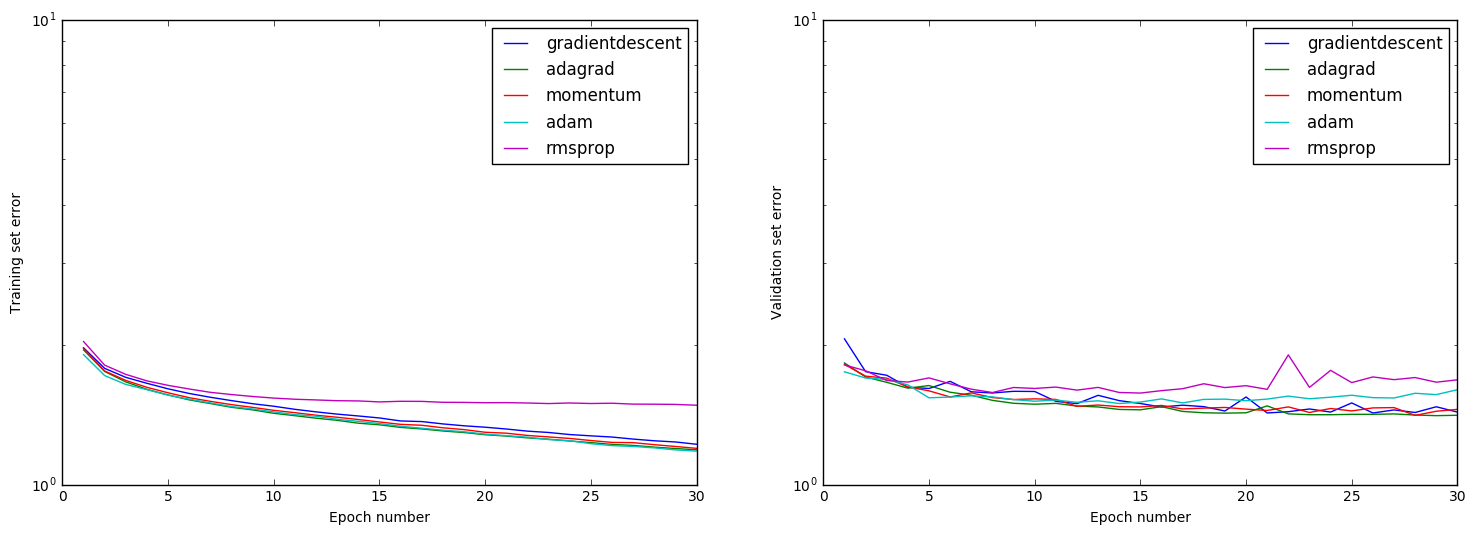

In [181]:
# Unpickle all important objects
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))

# Plot stuff
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for iter_str, stats_sub in stats.iteritems():
    ax1.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(train)'], label='{}'.format(iter_str))
    ax2.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(valid)'], label='{}'.format(iter_str))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

plt.savefig(os.path.join(save_path, 'optimizers.pdf'))

# Testing regularization

path created: run/coursework3-4/regularization/2017-02-15
deleting files in: run/coursework3-4/regularization/2017-02-15
L2 penalty: 0.0
End of epoch 01: err(train)=2.00 acc(train)=0.26 err(valid)=1.80 acc(valid)=0.35 time=6.71146392822
End of epoch 02: err(train)=1.78 acc(train)=0.35 err(valid)=1.73 acc(valid)=0.38 time=6.36047816277
End of epoch 03: err(train)=1.70 acc(train)=0.39 err(valid)=1.66 acc(valid)=0.40 time=6.23891019821
End of epoch 04: err(train)=1.64 acc(train)=0.41 err(valid)=1.73 acc(valid)=0.37 time=6.87188005447
End of epoch 05: err(train)=1.59 acc(train)=0.43 err(valid)=1.59 acc(valid)=0.44 time=7.99281215668
End of epoch 06: err(train)=1.56 acc(train)=0.44 err(valid)=1.58 acc(valid)=0.44 time=7.2024769783
End of epoch 07: err(train)=1.52 acc(train)=0.45 err(valid)=1.56 acc(valid)=0.44 time=6.70465612411
End of epoch 08: err(train)=1.49 acc(train)=0.46 err(valid)=1.55 acc(valid)=0.45 time=6.27737402916
End of epoch 09: err(train)=1.46 acc(train)=0.47 err(valid)=1.57

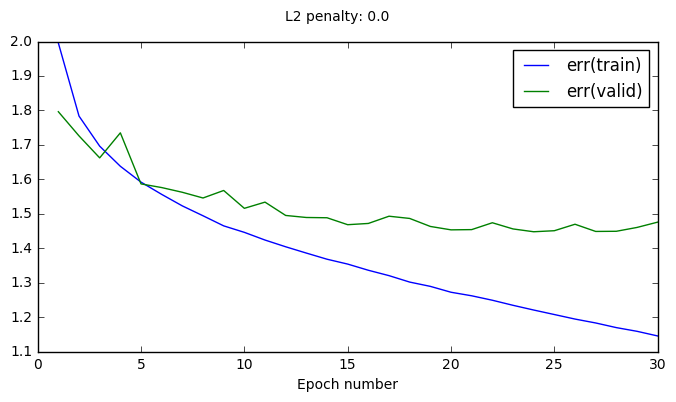

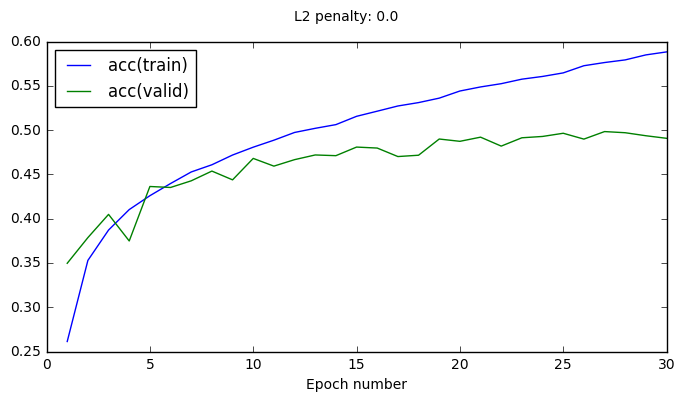

L2 penalty: 0.001
End of epoch 01: err(train)=2.71 acc(train)=0.27 err(valid)=2.52 acc(valid)=0.33 time=7.28105807304
End of epoch 02: err(train)=2.41 acc(train)=0.37 err(valid)=2.31 acc(valid)=0.39 time=7.35906100273
End of epoch 03: err(train)=2.25 acc(train)=0.39 err(valid)=2.18 acc(valid)=0.41 time=7.85109496117
End of epoch 04: err(train)=2.13 acc(train)=0.41 err(valid)=2.08 acc(valid)=0.43 time=8.05912399292
End of epoch 05: err(train)=2.03 acc(train)=0.43 err(valid)=2.03 acc(valid)=0.41 time=7.43797206879
End of epoch 06: err(train)=1.95 acc(train)=0.44 err(valid)=1.96 acc(valid)=0.43 time=7.65329194069
End of epoch 07: err(train)=1.87 acc(train)=0.45 err(valid)=1.88 acc(valid)=0.45 time=7.80513381958
End of epoch 08: err(train)=1.82 acc(train)=0.46 err(valid)=1.88 acc(valid)=0.44 time=7.67411208153
End of epoch 09: err(train)=1.77 acc(train)=0.47 err(valid)=1.78 acc(valid)=0.46 time=7.73569083214
End of epoch 10: err(train)=1.72 acc(train)=0.48 err(valid)=1.80 acc(valid)=0.44 t

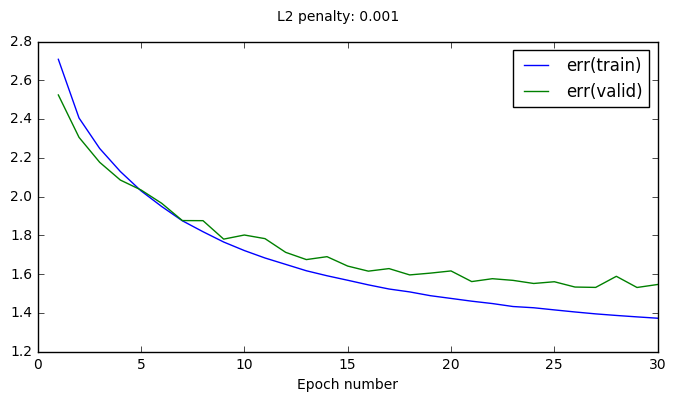

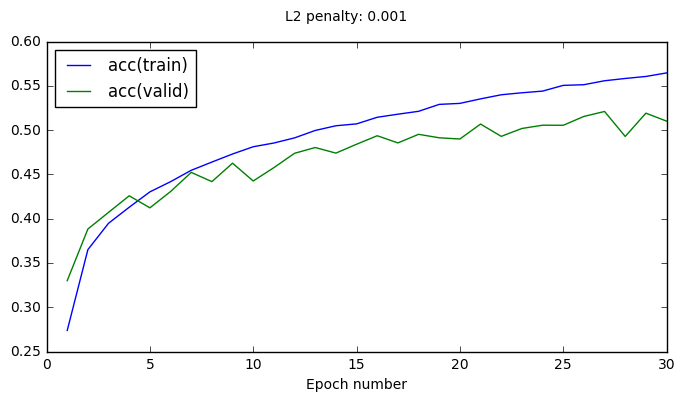

L2 penalty: 0.003
End of epoch 01: err(train)=4.87 acc(train)=0.27 err(valid)=4.21 acc(valid)=0.31 time=9.77833199501
End of epoch 02: err(train)=3.67 acc(train)=0.35 err(valid)=3.33 acc(valid)=0.35 time=8.69015812874
End of epoch 03: err(train)=2.96 acc(train)=0.38 err(valid)=2.74 acc(valid)=0.37 time=9.51362800598
End of epoch 04: err(train)=2.52 acc(train)=0.40 err(valid)=2.35 acc(valid)=0.42 time=10.2562749386
End of epoch 05: err(train)=2.23 acc(train)=0.42 err(valid)=2.14 acc(valid)=0.41 time=8.43932104111
End of epoch 06: err(train)=2.04 acc(train)=0.42 err(valid)=2.00 acc(valid)=0.42 time=8.33052301407
End of epoch 07: err(train)=1.92 acc(train)=0.43 err(valid)=1.90 acc(valid)=0.43 time=8.39334201813
End of epoch 08: err(train)=1.83 acc(train)=0.44 err(valid)=1.86 acc(valid)=0.42 time=8.54419803619
End of epoch 09: err(train)=1.77 acc(train)=0.45 err(valid)=1.76 acc(valid)=0.45 time=9.16214609146
End of epoch 10: err(train)=1.73 acc(train)=0.46 err(valid)=1.80 acc(valid)=0.43 t

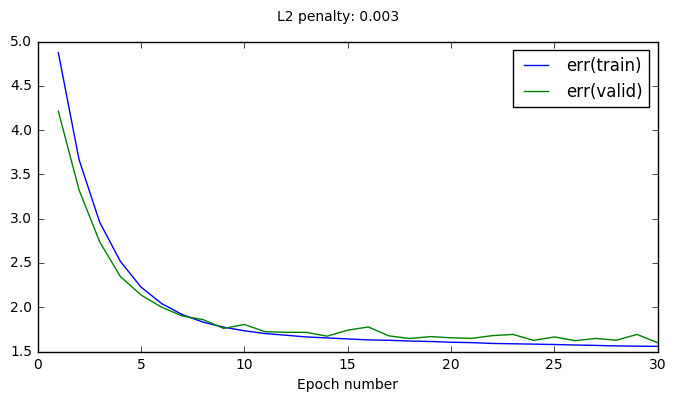

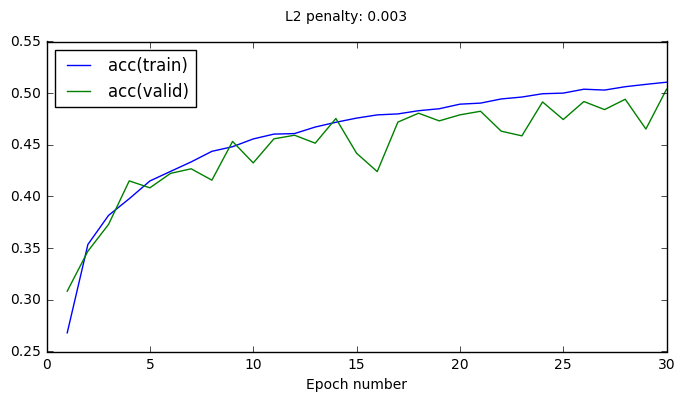

L2 penalty: 0.01
End of epoch 01: err(train)=10.21 acc(train)=0.27 err(valid)=5.53 acc(valid)=0.31 time=10.7580289841
End of epoch 02: err(train)=3.81 acc(train)=0.34 err(valid)=2.77 acc(valid)=0.36 time=10.3438179493
End of epoch 03: err(train)=2.39 acc(train)=0.36 err(valid)=2.21 acc(valid)=0.35 time=10.039026022
End of epoch 04: err(train)=2.06 acc(train)=0.37 err(valid)=1.96 acc(valid)=0.38 time=9.86157894135
End of epoch 05: err(train)=1.97 acc(train)=0.37 err(valid)=1.93 acc(valid)=0.39 time=9.81900906563
End of epoch 06: err(train)=1.94 acc(train)=0.38 err(valid)=1.91 acc(valid)=0.39 time=9.74723505974
End of epoch 07: err(train)=1.93 acc(train)=0.38 err(valid)=1.90 acc(valid)=0.40 time=11.1260719299
End of epoch 08: err(train)=1.92 acc(train)=0.39 err(valid)=1.94 acc(valid)=0.37 time=10.0574278831
End of epoch 09: err(train)=1.91 acc(train)=0.38 err(valid)=1.95 acc(valid)=0.37 time=10.7047410011
End of epoch 10: err(train)=1.91 acc(train)=0.39 err(valid)=1.93 acc(valid)=0.39 ti

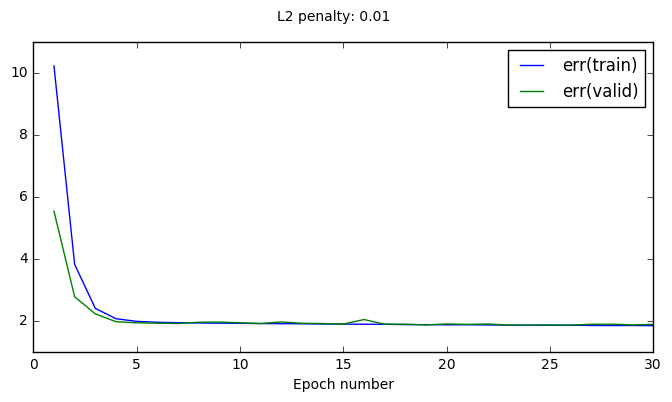

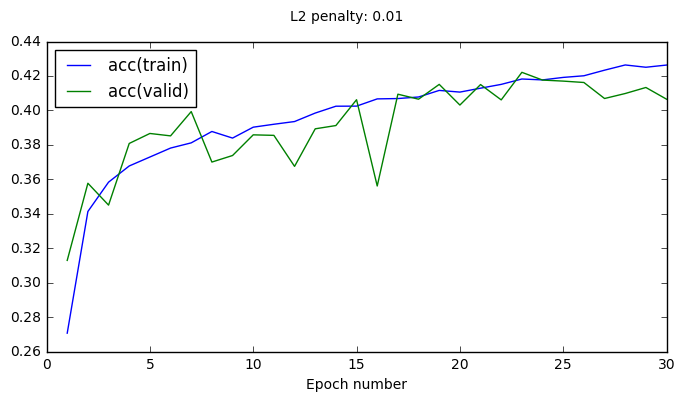

L2 penalty: 0.03
End of epoch 01: err(train)=15.28 acc(train)=0.22 err(valid)=2.86 acc(valid)=0.27 time=10.9163179398
End of epoch 02: err(train)=2.35 acc(train)=0.25 err(valid)=2.24 acc(valid)=0.24 time=12.2383549213
End of epoch 03: err(train)=2.18 acc(train)=0.24 err(valid)=2.16 acc(valid)=0.24 time=11.2149779797
End of epoch 04: err(train)=2.17 acc(train)=0.25 err(valid)=2.14 acc(valid)=0.26 time=10.663424015
End of epoch 05: err(train)=2.16 acc(train)=0.25 err(valid)=2.18 acc(valid)=0.23 time=10.1543369293
End of epoch 06: err(train)=2.15 acc(train)=0.25 err(valid)=2.14 acc(valid)=0.26 time=13.2941389084
End of epoch 07: err(train)=2.15 acc(train)=0.25 err(valid)=2.15 acc(valid)=0.26 time=11.4332699776
End of epoch 08: err(train)=2.14 acc(train)=0.25 err(valid)=2.13 acc(valid)=0.27 time=12.5735208988
End of epoch 09: err(train)=2.14 acc(train)=0.26 err(valid)=2.12 acc(valid)=0.27 time=11.1195580959
End of epoch 10: err(train)=2.14 acc(train)=0.26 err(valid)=2.12 acc(valid)=0.26 ti

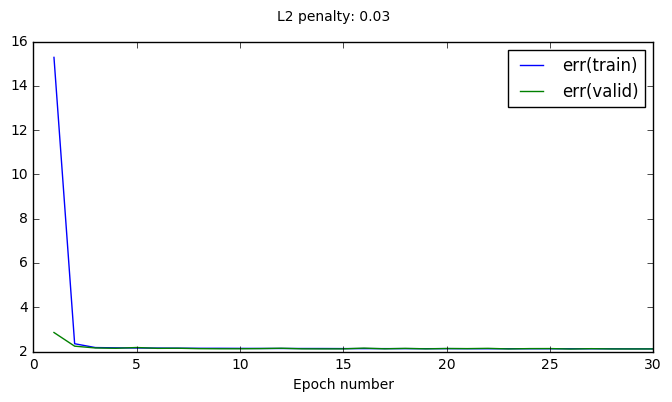

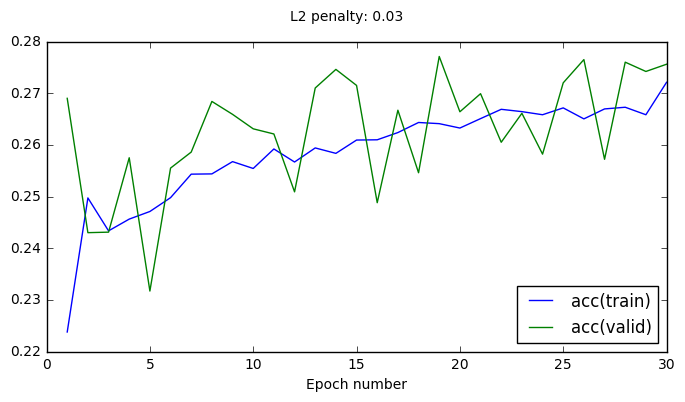

L2 penalty: 0.1
End of epoch 01: err(train)=18.63 acc(train)=0.16 err(valid)=2.37 acc(valid)=0.18 time=14.4130859375
End of epoch 02: err(train)=2.36 acc(train)=0.16 err(valid)=2.34 acc(valid)=0.15 time=11.5092670918
End of epoch 03: err(train)=2.34 acc(train)=0.16 err(valid)=2.34 acc(valid)=0.16 time=10.8934521675
End of epoch 04: err(train)=2.34 acc(train)=0.16 err(valid)=2.34 acc(valid)=0.16 time=11.6382529736
End of epoch 05: err(train)=2.34 acc(train)=0.16 err(valid)=2.34 acc(valid)=0.17 time=11.7888400555
End of epoch 06: err(train)=2.34 acc(train)=0.16 err(valid)=2.34 acc(valid)=0.16 time=11.5214879513
End of epoch 07: err(train)=2.34 acc(train)=0.16 err(valid)=2.35 acc(valid)=0.14 time=11.7842040062
End of epoch 08: err(train)=2.34 acc(train)=0.16 err(valid)=2.34 acc(valid)=0.14 time=11.3651299477
End of epoch 09: err(train)=2.34 acc(train)=0.16 err(valid)=2.34 acc(valid)=0.17 time=11.2133281231
End of epoch 10: err(train)=2.34 acc(train)=0.16 err(valid)=2.34 acc(valid)=0.15 ti

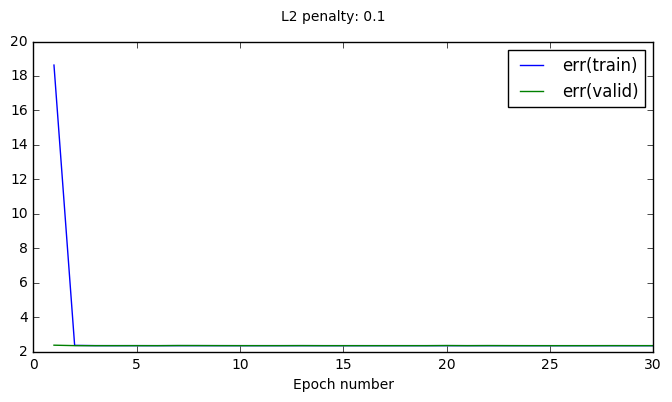

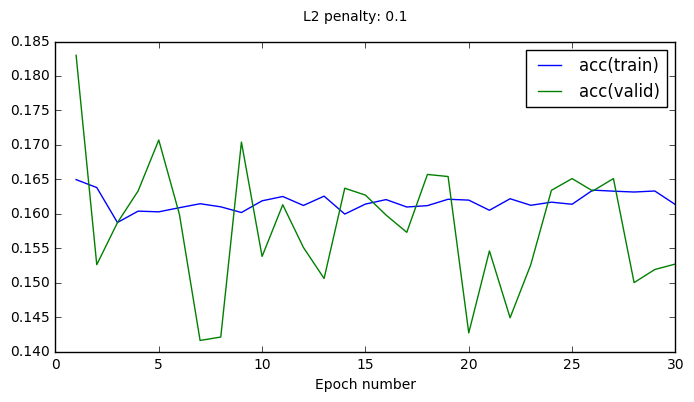

L2 penalty: 0.3
End of epoch 01: err(train)=22.71 acc(train)=0.10 err(valid)=2.30 acc(valid)=0.10 time=13.7174770832
End of epoch 02: err(train)=2.30 acc(train)=0.10 err(valid)=2.30 acc(valid)=0.10 time=15.5384480953
End of epoch 03: err(train)=2.30 acc(train)=0.10 err(valid)=2.30 acc(valid)=0.10 time=14.4811630249
End of epoch 04: err(train)=2.30 acc(train)=0.10 err(valid)=2.30 acc(valid)=0.10 time=13.83426404
End of epoch 05: err(train)=2.30 acc(train)=0.10 err(valid)=2.30 acc(valid)=0.10 time=14.9103209972
End of epoch 06: err(train)=2.30 acc(train)=0.10 err(valid)=2.30 acc(valid)=0.10 time=15.1277520657
End of epoch 07: err(train)=2.30 acc(train)=0.10 err(valid)=2.30 acc(valid)=0.10 time=13.9129440784
End of epoch 08: err(train)=2.30 acc(train)=0.10 err(valid)=2.30 acc(valid)=0.10 time=12.5805659294
End of epoch 09: err(train)=2.30 acc(train)=0.10 err(valid)=2.30 acc(valid)=0.10 time=12.4570200443
End of epoch 10: err(train)=2.30 acc(train)=0.10 err(valid)=2.30 acc(valid)=0.10 time

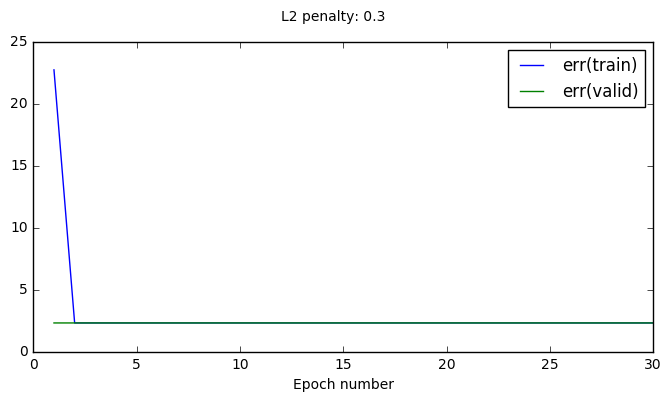

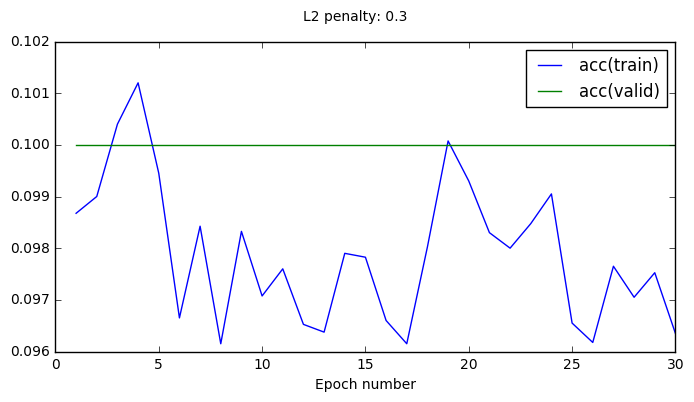

In [8]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'regularization'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

num_hlayers = 4
num_hidden = 100

learning_rate = 0.03

stats = OrderedDict()

num_epoch = 30
stats_interval = 1

penalties = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
iter_strs = ['L2 penalty: ' + str(p) for p in penalties]
if len(iter_strs) != len(penalties):
    print 'lengths DO NOT match. Bad!!!'

for penalty, iter_str in zip(penalties, iter_strs):
    
    print '=========='
    print '{}'.format(iter_str)
    stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
    
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    # Initialize hidden layers
    hlayers = []
    
    # Create first hidden layer. There must be at least one.
    with tf.name_scope('fc-layer-1'):
        hlayers.append(fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden))
    
    # Create second, third, etc. hidden layers (if they exist)
    for hl in range(num_hlayers - 1):
        fc_layer_num = hl + 2
        with tf.name_scope('fc-layer-{}'.format(fc_layer_num)):
            hlayers.append(fully_connected_layer(hlayers[-1], num_hidden, num_hidden))

    # Create output layer
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hlayers[-1], num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        # http://stackoverflow.com/a/38466108
        lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables() if 'bias' not in v.name]) * penalty
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets) + lossL2)
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))
        
    with tf.name_scope('train'):
        train_step = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(error)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:

        sess.run(init)
        t0 = time.time()

        for e in range(num_epoch):

            t0_epoch = time.time()
            
            # Training
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            
            # Validation
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} err(valid)={3:.2f} acc(valid)={4:.2f} time={5}'
                  .format(e + 1, running_error, running_accuracy, valid_error, valid_accuracy, time.time()-t0_epoch))

            # Store metrics
            stats_one['err(train)'].append(running_error)
            stats_one['acc(train)'].append(running_accuracy)
            stats_one['err(valid)'].append(valid_error)
            stats_one['acc(valid)'].append(valid_accuracy)
            
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['err(train)', 'err(valid)']:
        ax_1.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    fig_1.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'error_' + iter_str + '.pdf'))

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    fig_2.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'acc_' + iter_str + '.pdf'))
                  
    plt.show()

    stats_one['time'] = time.time() - t0
    stats[iter_str] = stats_one

# Pickle all important objects
pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

path created: run/coursework3-4/regularization/2017-02-15


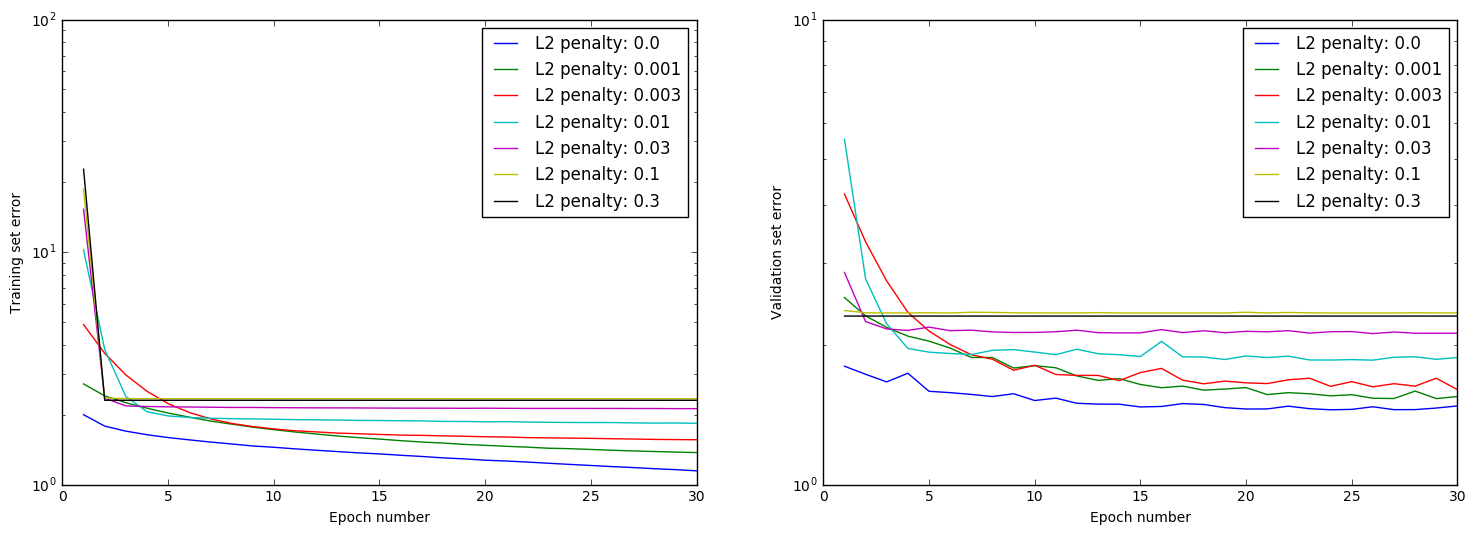

In [9]:
# Unpickle all important objects
subdir = 'regularization'
save_path = create_and_return_path(subdir, save_path_main)
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))

# Plot stuff
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for iter_str, stats_sub in stats.iteritems():
    ax1.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(train)'], label='{}'.format(iter_str))
    ax2.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(valid)'], label='{}'.format(iter_str))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

plt.savefig(os.path.join(save_path, 'regularization.pdf'))

# Testing batch normalization

In [ ]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

In [16]:
# # http://r2rt.com/implementing-batch-normalization-in-tensorflow.html
# def fully_connected_layer_batch_norm(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu, epsilon=1e-6):
#     weights = tf.Variable(
#         tf.truncated_normal(
#             [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
#         'weights')
#     z1_BN = tf.matmul(inputs, weights)
#     batch_mean1, batch_var1 = tf.nn.moments(z1_BN, [0])
#     z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
#     scale1 = tf.Variable(tf.ones([output_dim]))
#     beta1 = tf.Variable(tf.zeros([output_dim]))
#     BN1 = scale1 * z1_hat + beta1
#     outputs = nonlinearity(BN1)
#     return outputs

In [19]:
# http://r2rt.com/implementing-batch-normalization-in-tensorflow.html
def fully_connected_layer_batch_norm(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu, epsilon=1e-6):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    z1_BN = tf.matmul(inputs, weights)
    batch_mean1, batch_var1 = tf.nn.moments(z1_BN, [0])
    z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
    scale1 = tf.Variable(tf.ones([output_dim]))
    beta1 = tf.Variable(tf.zeros([output_dim]))
    BN1 = tf.nn.batch_normalization(z1_BN, batch_mean1, batch_var1, beta1, scale1, epsilon)
    outputs = nonlinearity(BN1)
    return outputs

path created: run/coursework3-4/batch_norm/2017-02-15
deleting files in: run/coursework3-4/batch_norm/2017-02-15
non-batch norm layers
End of epoch 01: err(train)=1.94 acc(train)=0.29 err(valid)=1.80 acc(valid)=0.35 time=7.06007289886
End of epoch 02: err(train)=1.74 acc(train)=0.37 err(valid)=1.76 acc(valid)=0.37 time=6.99688792229
End of epoch 03: err(train)=1.66 acc(train)=0.41 err(valid)=1.68 acc(valid)=0.40 time=7.68593192101
End of epoch 04: err(train)=1.61 acc(train)=0.43 err(valid)=1.61 acc(valid)=0.42 time=6.56960892677
End of epoch 05: err(train)=1.56 acc(train)=0.44 err(valid)=1.60 acc(valid)=0.44 time=6.49676299095
End of epoch 06: err(train)=1.53 acc(train)=0.46 err(valid)=1.56 acc(valid)=0.44 time=6.55547785759
End of epoch 07: err(train)=1.50 acc(train)=0.46 err(valid)=1.54 acc(valid)=0.46 time=8.03693699837
End of epoch 08: err(train)=1.47 acc(train)=0.48 err(valid)=1.50 acc(valid)=0.47 time=6.91995716095
End of epoch 09: err(train)=1.45 acc(train)=0.49 err(valid)=1.50 

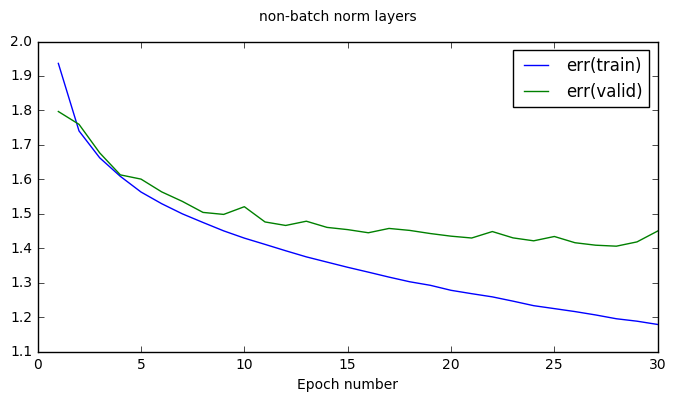

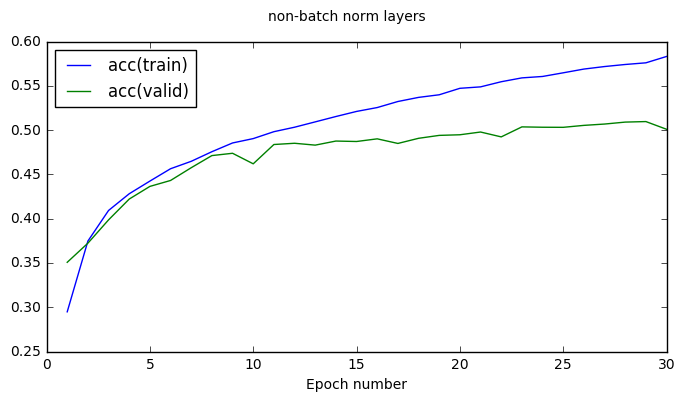

batch norm layers
End of epoch 01: err(train)=1.80 acc(train)=0.36 err(valid)=1.68 acc(valid)=0.40 time=11.2234909534
End of epoch 02: err(train)=1.60 acc(train)=0.44 err(valid)=1.60 acc(valid)=0.43 time=11.0940561295
End of epoch 03: err(train)=1.52 acc(train)=0.47 err(valid)=1.57 acc(valid)=0.45 time=10.1146428585
End of epoch 04: err(train)=1.47 acc(train)=0.49 err(valid)=1.54 acc(valid)=0.46 time=12.1842689514
End of epoch 05: err(train)=1.43 acc(train)=0.50 err(valid)=1.52 acc(valid)=0.47 time=12.6603658199
End of epoch 06: err(train)=1.39 acc(train)=0.52 err(valid)=1.52 acc(valid)=0.47 time=12.1540489197
End of epoch 07: err(train)=1.36 acc(train)=0.53 err(valid)=1.52 acc(valid)=0.47 time=11.7534298897
End of epoch 08: err(train)=1.33 acc(train)=0.54 err(valid)=1.51 acc(valid)=0.47 time=9.80488181114
End of epoch 09: err(train)=1.30 acc(train)=0.55 err(valid)=1.50 acc(valid)=0.48 time=9.52862381935
End of epoch 10: err(train)=1.27 acc(train)=0.56 err(valid)=1.50 acc(valid)=0.47 t

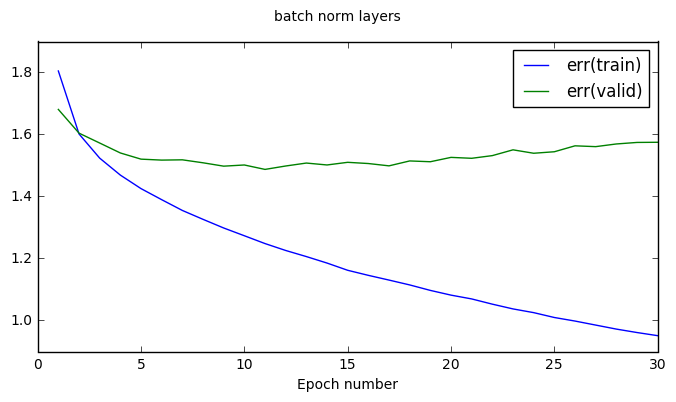

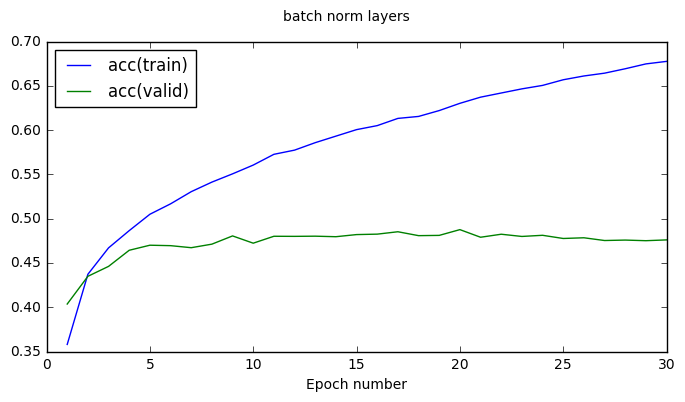

In [22]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'batch_norm'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

num_hlayers = 4
num_hidden = 100

learning_rate = 0.01

stats = OrderedDict()

num_epoch = 30
stats_interval = 1

layer_types = [fully_connected_layer, fully_connected_layer_batch_norm]
iter_strs = ['non-batch norm layers', 'batch norm layers']
if len(iter_strs) != len(layer_types):
    print 'lengths DO NOT match. Bad!!!'

for layer_type, iter_str in zip(layer_types, iter_strs):
    
    print '=========='
    print '{}'.format(iter_str)
    stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}

    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

    hlayers = []

    # Create first hidden layer. There must be at least one.
    with tf.name_scope('fc-layer-1'):
        hlayers.append(layer_type(inputs, train_data.inputs.shape[1], num_hidden))

    # Create second, third, etc. hidden layers (if they exist)
    for hl in range(num_hlayers - 1):
        fc_layer_num = hl + 2
        with tf.name_scope('fc-layer-{}'.format(fc_layer_num)):
            hlayers.append(layer_type(hlayers[-1], num_hidden, num_hidden))

    # Create output layer
    with tf.name_scope('output-layer'):
        outputs = layer_type(hlayers[-1], num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(error)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:

        sess.run(init)
        t0 = time.time()

        for e in range(num_epoch):

            t0_epoch = time.time()

            # Training
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches

            # Validation
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches

            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} err(valid)={3:.2f} acc(valid)={4:.2f} time={5}'
                  .format(e + 1, running_error, running_accuracy, valid_error, valid_accuracy, time.time()-t0_epoch))

            # Store metrics
            stats_one['err(train)'].append(running_error)
            stats_one['acc(train)'].append(running_accuracy)
            stats_one['err(valid)'].append(valid_error)
            stats_one['acc(valid)'].append(valid_accuracy)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['err(train)', 'err(valid)']:
        ax_1.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    fig_1.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'error_' + iter_str + '.pdf'))

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    fig_2.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'acc_' + iter_str + '.pdf'))

    plt.show()

    stats_one['time'] = time.time() - t0
    stats[iter_str] = stats_one

# Pickle all important objects
pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

In [36]:
stats['non-batch norm layers']['time']

205.18226099014282

path created: run/coursework3-4/batch_norm/2017-02-15


ValueError: x and y must have same first dimension

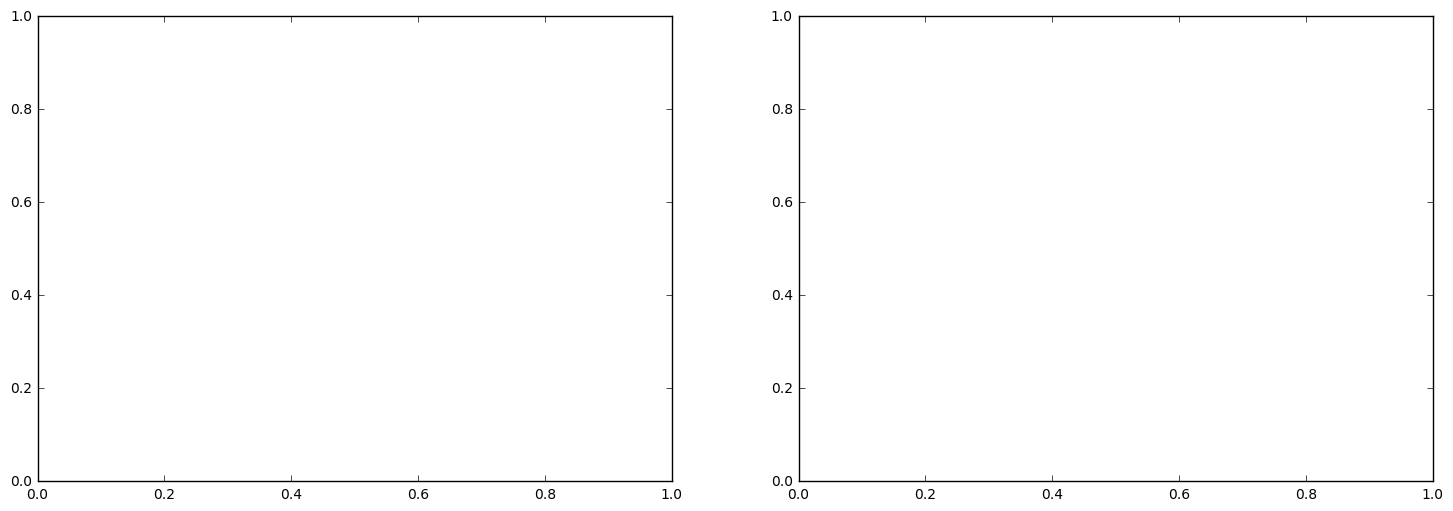

In [33]:
# Unpickle all important objects
subdir = 'batch_norm'
save_path = create_and_return_path(subdir, save_path_main)
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))

# Plot stuff
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for iter_str, stats_sub in stats.iteritems():
    ax1.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(train)'], label='{}'.format(iter_str))
    ax2.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(valid)'], label='{}'.format(iter_str))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

plt.savefig(os.path.join(save_path, 'batch_norm.pdf'))

# Application to CIFAR-100

path created: run/coursework3-4/cifar-100/2017-02-15
deleting files in: run/coursework3-4/cifar-100/2017-02-15
lengths DO NOT match. Bad!!!

End of epoch 01: err(train)=4.23 acc(train)=0.08 err(valid)=3.95 acc(valid)=0.11 time=11.4603071213
End of epoch 02: err(train)=3.84 acc(train)=0.13 err(valid)=3.80 acc(valid)=0.13 time=11.1150810719
End of epoch 03: err(train)=3.70 acc(train)=0.15 err(valid)=3.73 acc(valid)=0.15 time=11.685901165
End of epoch 04: err(train)=3.61 acc(train)=0.17 err(valid)=3.67 acc(valid)=0.15 time=10.9759440422
End of epoch 05: err(train)=3.54 acc(train)=0.18 err(valid)=3.63 acc(valid)=0.16 time=12.9746160507
End of epoch 06: err(train)=3.48 acc(train)=0.19 err(valid)=3.60 acc(valid)=0.17 time=11.1906549931
End of epoch 07: err(train)=3.44 acc(train)=0.19 err(valid)=3.58 acc(valid)=0.17 time=10.777785778
End of epoch 08: err(train)=3.39 acc(train)=0.20 err(valid)=3.57 acc(valid)=0.17 time=10.5614218712
End of epoch 09: err(train)=3.35 acc(train)=0.21 err(valid)=3

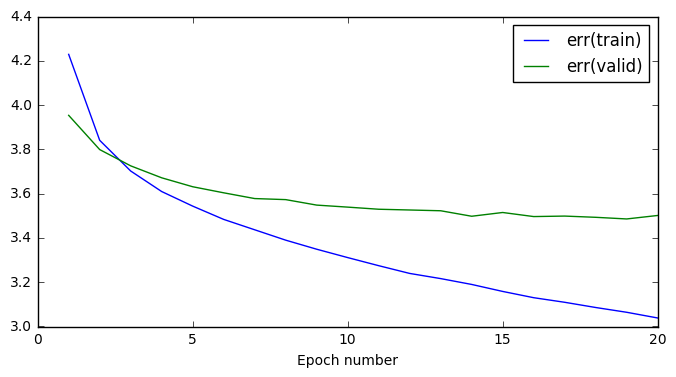

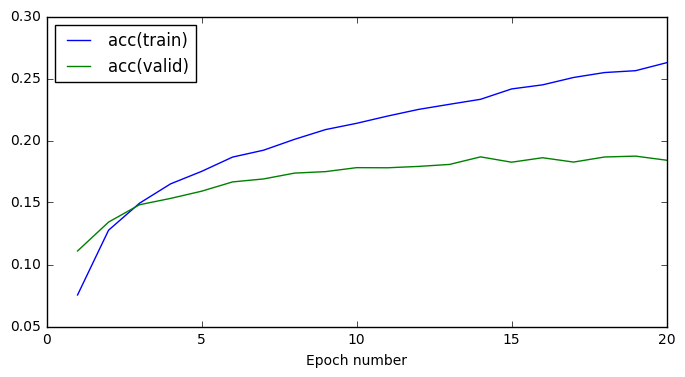

In [27]:
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)

# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'cifar-100'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

num_hlayers = 4
num_hidden = 100

learning_rate = 0.01

stats = OrderedDict()

num_epoch = 20
stats_interval = 1

dummy_list = [0]
iter_strs = ['']
if len(iter_strs) != len(layer_types):
    print 'lengths DO NOT match. Bad!!!'

for _, iter_str in zip(dummy_list, iter_strs):
    
    print '=========='
    print '{}'.format(iter_str)
    stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}

    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

    hlayers = []

    # Create first hidden layer. There must be at least one.
    with tf.name_scope('fc-layer-1'):
        hlayers.append(layer_type(inputs, train_data.inputs.shape[1], num_hidden))

    # Create second, third, etc. hidden layers (if they exist)
    for hl in range(num_hlayers - 1):
        fc_layer_num = hl + 2
        with tf.name_scope('fc-layer-{}'.format(fc_layer_num)):
            hlayers.append(layer_type(hlayers[-1], num_hidden, num_hidden))

    # Create output layer
    with tf.name_scope('output-layer'):
        outputs = layer_type(hlayers[-1], num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(error)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:

        sess.run(init)
        t0 = time.time()

        for e in range(num_epoch):

            t0_epoch = time.time()

            # Training
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches

            # Validation
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches

            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} err(valid)={3:.2f} acc(valid)={4:.2f} time={5}'
                  .format(e + 1, running_error, running_accuracy, valid_error, valid_accuracy, time.time()-t0_epoch))

            # Store metrics
            stats_one['err(train)'].append(running_error)
            stats_one['acc(train)'].append(running_accuracy)
            stats_one['err(valid)'].append(valid_error)
            stats_one['acc(valid)'].append(valid_accuracy)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['err(train)', 'err(valid)']:
        ax_1.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    fig_1.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'error_' + iter_str + '.pdf'))

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    fig_2.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'acc_' + iter_str + '.pdf'))

    plt.show()

    stats_one['time'] = time.time() - t0
    stats[iter_str] = stats_one

# Pickle all important objects
pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)

path created: run/coursework3-4/cifar-100/2017-02-15


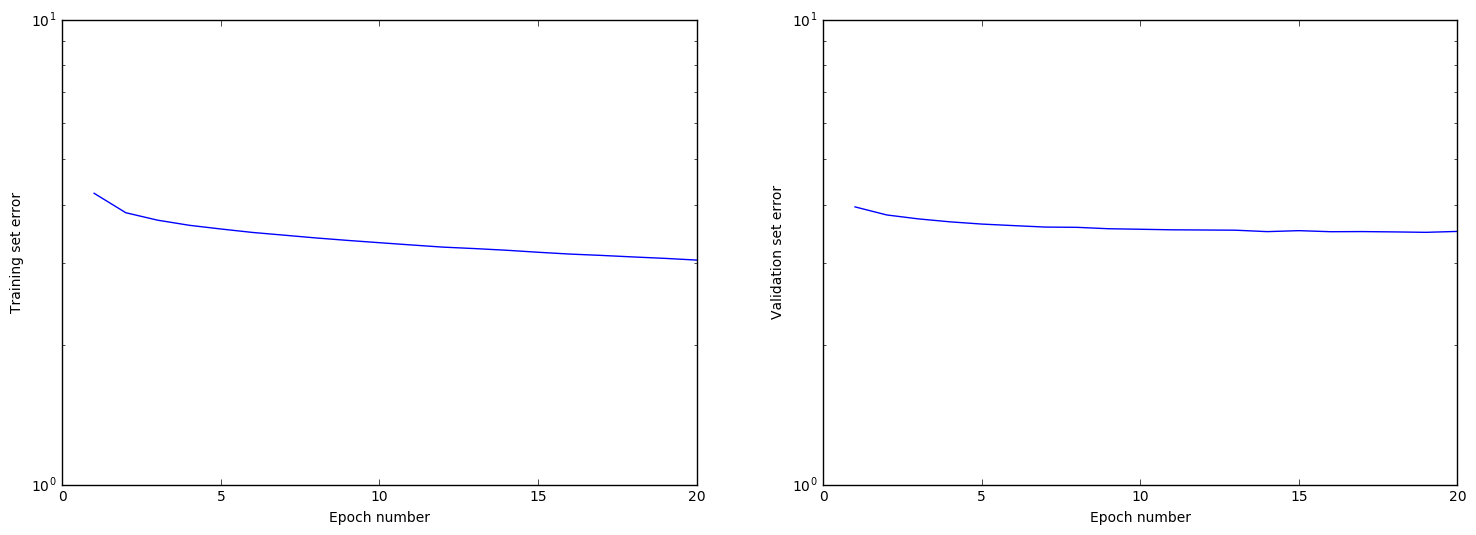

In [30]:
# Unpickle all important objects
subdir = 'cifar-100'
save_path = create_and_return_path(subdir, save_path_main)
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))

# Plot stuff
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for iter_str, stats_sub in stats.iteritems():
    ax1.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(train)'], label='{}'.format(iter_str))
    ax2.plot(np.arange(1, num_epoch + 1), 
             stats_sub['err(valid)'], label='{}'.format(iter_str))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

plt.savefig(os.path.join(save_path, 'cifar-100.pdf'))